# Kernel Derivatives: Regularization

Date: 4th December, 2017

In this notebook, I will be exploring how some different derivatives can be used as regularization parameters. This will be used in the context of Kernel Ridge Regression (KRR) and Gaussian Process Regression (GPR).

The general regression problem:

$$\mathcal{C} = \frac{1}{n} \sum \phi \left( y_i, f(x_i) \right) + \text{ penalty}(f)$$

where:

* $\phi$ is the estimation error 
* penalty($f$) is the regularization term.

Assume we have the following cost function for ridge regression where we have a regularization penalty (scaled by $\lambda$) added to the cost term like so ([1]):

$$\mathcal{C} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - f(x_i) \right)^2 + \lambda ||f||^{2}_{\mathcal{H}}$$

where:

* $\alpha$ are the weights
* $K$ is the kernel matrix
* $\lambda$ is the trade off parameter between the regularization and the mean squared error.
* $\Omega$ is the regularization that we choose (e.g. $||w||$, $||f||$, $||\partial f||$, $||\partial^2 f||$)

[1]: https://people.eecs.berkeley.edu/~bartlett/courses/281b-sp08/10.pdf

This results in the following formula:

$$\mathbf{w} = (\mathbf{x}^T\mathbf{x}+ \lambda \mathbf{I})^{-1} \mathbf{x}^T \mathbf{y}$$

## Derivation

Let 

In [1]:
import numpy as np

from time import time

from scipy.spatial.distance import pdist

from sklearn.metrics import (make_scorer, mean_squared_error)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import (GridSearchCV, learning_curve, 
                                     validation_curve, StratifiedShuffleSplit)

from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

In [2]:
# set the seed to zero for reproducibility
seed = 123
np.random.seed(seed)

x = {}
y = {}

# ----------------------------------
# GENERATE SIGNAL
# ----------------------------------

# generate an x signal between 0 and 20.
num_train = 100
num_test = 100
x['data'] = np.linspace(0, 3*np.pi, num=num_train)[:, np.newaxis]       # generate points between 0 and 20
x['plot'] = np.linspace(0, 3*np.pi, num=num_test)[:, np.newaxis]

# signal function (analytical)
def f(x, scaling=0.1, n_derivative=0):
    
    # 0th derivative
    if n_derivative is 0:
        
        value =  np.sin(2 * np.pi * scaling * x)
    
    # 1st derivative
    elif n_derivative is 1:
        
        value = (2 * np.pi * scaling) * np.cos(2 * np.pi * scaling * x)
    
    # 2nd derivative
    elif n_derivative is 2:
        
        value = -(2 * np.pi * scaling)**2 * np.sin(2 * np.pi * scaling * x)
    
    else:
        raise ValueError('Value needs to be between 0 and 1.')
        
    return value

def get_derivative(func, x):
    h = 0.0001
    return (func(x + h) - func(x)) / h

x['signal'] = f(x['data'])                   # 2 + sin(x)
x['signal'] = x['signal']/x['signal'].max()  # normalize
std_signal = np.std(x['signal'])          



print('Standard Deviation, Signal: {:.3f}\n'.format(std_signal))

# ----------------------------------
# GENERATE NOISE
# ----------------------------------

# generate a noise sample with a sc
std_noise = 0.3    # scale parameter of 0.1

print('Standard Deviation, Noise: {:.3f}\n'.format(std_noise))

snr = 20 * np.log(np.std(x['data'])/std_noise)

print('Signal-to-Noise Ratio (SNR): {:.3f}\n'.format(snr))

size = np.shape(x['data'])

x['noise'] = np.random.normal(scale=std_noise, size=size)

# ----------------------------------
# GENERATE DATA
# ----------------------------------

y['data'] = x['signal'] + x['noise']

#
# ANALYTICAL DERIVATIVES
# 

gs_model = {}

Standard Deviation, Signal: 0.723

Standard Deviation, Noise: 0.300

Signal-to-Noise Ratio (SNR): 44.297



### Custom Kernel Ridge Regression Function

In [3]:
class KRR(BaseEstimator, RegressorMixin):
    """Kernel Ridge Regression with different classifiers.
    An implementation of KRR algorithm with different
    regularization parameters.


    Parameters
    ----------
    reg : str, {'w', 'f', 'df', 'df2'}
        the regularization parameter associated with the
        KRR solution

        alpha = inv(K + lam reg) * y

    sigma : float, optional(default=None)
        the parameter for the kernel function.

    lam : float, options(default=None)
        the trade-off parameter between the mean squared error
        and the regularization term.

    Attributes
    ----------
    weights_ : array, [N x D]
        the weights found from the matrix

    K_ : array, [N x N]
        the kernel matrix with sigma parameter
    """
    def __init__(self, reg=None, sigma=None, lam=None):
        self.reg = reg
        self.sigma = sigma
        self.lam = lam
        
    def fit(self, X, y=None):
        
        # regularization 
        if self.reg is None:
            self.reg = 'w'
        elif self.reg not in ['w', 'df', 'd2f']:
            raise ValueError('Unrecognized regularization.')
        
        # regularization trade off parameter
        if self.lam is None:
            self.lam = 1.0e-4
            
        # kernel length scale parameter
        if self.sigma is None:
            self.sigma = np.mean(pdist(X, metric='euclidean'))
        
        # gamma parameter for the scikit-learn kernel matrix
        self.gamma = 1 / (2 * self.sigma**2)
        
        # kernel function
        self.X_fit_ = X
        self.K_ = rbf_kernel(self.X_fit_, Y=X, gamma=self.gamma)
                
        # Regularization with the weights
        if self.reg is 'w':
            
            # regularization simple
            regularization = np.eye(np.size(X))
            
            # solve for the weights
            self.weights_ = np.linalg.solve(self.K_ + self.lam * regularization, y)
            
        # Regularization with the derivative
        elif self.reg is 'df':
            
            theta = 2 * self.gamma
            
            # initialize derivative
            self.derivative_ = np.zeros(np.shape(self.X_fit_ ))
            
            # loop through dimensions
            for dim in np.arange(0, np.shape(self.X_fit_ )[1]):

                # loop through the number of test points
                for iTest in np.arange(0, np.shape(self.X_fit_ )[0]):

                    # loop through the number of test points
                    for iTrain in np.arange(0, np.shape(self.X_fit_ )[0]):

                        self.derivative_[iTest, dim] += theta * \
                                                  (self.X_fit_[iTrain, dim] -
                                                   self.X_fit_[iTest, dim]) * \
                                                  self.K_[iTrain, iTest]
                        
            # solve for the weights
            self.weights_ = np.linalg.solve(np.dot(self.K_, self.K_) + 
                                            self.lam * self.derivative_**2, 
                                            np.dot(self.K_, y))
            
        # Regularization with the second derivative
        elif self.reg is 'd2f':
            
            theta = 2 * self.gamma
            
            # initialize derivative
            self.derivative2_ = np.zeros(np.shape(self.X_fit_ ))
            
            # loop through dimensions
            for dim in np.arange(0, np.shape(self.X_fit_ )[1]):

                # loop through the number of test points
                for iTest in np.arange(0, np.shape(self.X_fit_ )[0]):

                    # loop through the number of test points
                    for iTrain in np.arange(0, np.shape(self.X_fit_ )[0]):

                        self.derivative2_[iTest, dim] += (theta**2 *
                                                   (self.X_fit_[iTrain, dim] - 
                                                    self.X_fit_[iTest, dim])**2
                                                   - theta) * self.K_[iTrain, iTest]
                        
            # solve for the weights
            self.weights_ = np.linalg.solve(np.dot(self.K_, self.K_) + self.lam * 
                                            self.derivative2_**2, 
                                            np.dot(self.K_, y))
        else:
            raise ValueError('Unrecognized reg parameter.')
                
        return self
    
    def predict(self, x):
        
        # calculate the kernel function with new points
        K = rbf_kernel(x, self.X_fit_, gamma=self.gamma)
        
        return np.dot(K, self.weights_)
    

### KRR ($||w||$)

In [4]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-2, 2, num=10)
lam_candidates = np.logspace(-7, 10, num=10)

parameter_grid = dict(sigma=sigma_candidates,
                      lam=lam_candidates)

# initialize grid search class
gs_model['w'] = GridSearchCV(estimator=KRR(reg='w'),
                             param_grid=parameter_grid,
                             n_jobs=-1,
                             verbose=1,
                             cv=2,
                             scoring='neg_mean_absolute_error',
                             return_train_score=True)
        
# train classifier
gs_model['w'].fit(x['data'], y['data'])

# View the accuracy score
print('Best score for ||w||:', gs_model['w'].best_score_) 

# View the best parameters for the model found using grid search
best_lambda = gs_model['w'].best_estimator_.lam
best_sigma = gs_model['w'].best_estimator_.sigma
print('Best sigma:', best_sigma) 
print('Best lambda:', best_lambda)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best score for ||w||: -0.635980073986
Best sigma: 4.64158883361
Best lambda: 0.0464158883361


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [5]:
# gather scores
scores = gs_model['w'].cv_results_['mean_test_score'].reshape(len(lam_candidates),
                                                               len(sigma_candidates))

# scale scores
scores = scores/scores.max()

min_sig = np.argmin(scores, axis=0)
min_lam = np.argmin(scores, axis=1)

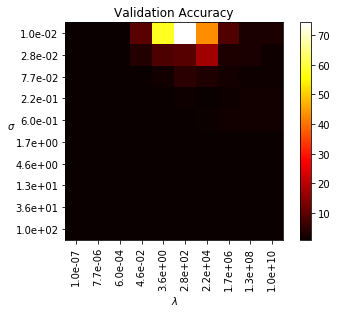

In [6]:

fig, ax = plt.subplots()

cax = ax.imshow(scores, cmap=plt.cm.hot)
# plt.scatter(min_sig, min_lam,
#          color='green', marker='+',s=20)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()

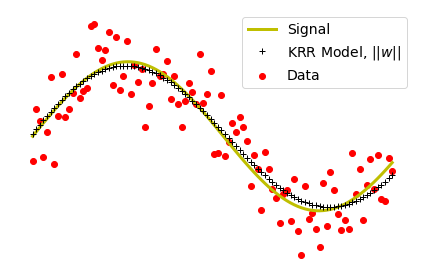

In [7]:
# initialize model
krr_model = KRR(reg='w',
                lam=best_lambda,
                sigma=best_sigma)

# fit to data
krr_model.fit(x['data'], y['data'])

# predict
y_pred = krr_model.predict(x['plot'])


fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['plot'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||w||$')

# plot data
ax.scatter(x['data'], y['data'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

## Kernel Ridge Regression ($\partial f$)

In [14]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-2, 2, num=10)
lam_candidates = np.logspace(-7, 1, num=10)

parameter_grid = dict(sigma=sigma_candidates,
                      lam=lam_candidates)

# initialize grid search class
gs_model['df'] = GridSearchCV(estimator=KRR(reg='df'),
                             param_grid=parameter_grid,
                             n_jobs=1,
                             verbose=1,
                             cv=2,
                             scoring='neg_mean_absolute_error',
                             return_train_score=True)
        
# train classifier
gs_model['df'].fit(x['data'], y['data'])

# View the accuracy score
print(r'Best score for $||\partial f||$:', gs_model['df'].best_score_) 

# View the best parameters for the model found using grid search
print('Best sigma:',gs_model['df'].best_estimator_.sigma) 
print('Best lambda:',gs_model['df'].best_estimator_.lam)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best score for $||\partial f||$: -0.685999738757
Best sigma: 0.0774263682681
Best lambda: 0.00035938136638


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


In [15]:
# gather scores
scores = gs_model['df'].cv_results_['mean_test_score'].reshape(len(lam_candidates),
                                                               len(sigma_candidates))

# scale scores
scores = scores/scores.max()

min_sig = np.argmin(scores, axis=1)
min_lam = np.argmin(scores, axis=0)

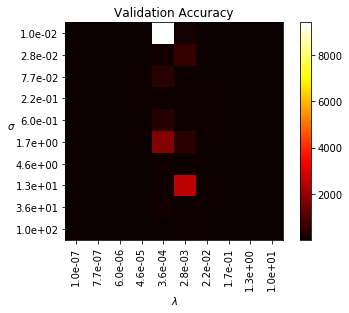

In [16]:
fig, ax = plt.subplots()

cax = ax.imshow(scores, cmap=plt.cm.hot)
# plt.scatter(min_sig, min_lam,
#          color='green', marker='+',s=20)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()

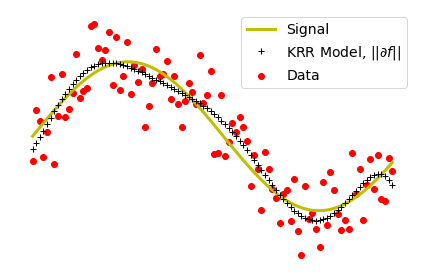

In [17]:
# initialize model
krr_model = KRR(reg='df',
                lam=best_lambda,
                sigma=best_sigma)

# fit to data
krr_model.fit(x['data'], y['data'])

# predict
y_pred = krr_model.predict(x['plot'])


fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['plot'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||\partial f||$')

# plot data
ax.scatter(x['data'], y['data'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

### KRR ($||\partial^2 f||$)

In [21]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-2, 2, num=10)
lam_candidates = np.logspace(-7, 3, num=10)

parameter_grid = dict(sigma=sigma_candidates,
                      lam=lam_candidates)

# initialize grid search class
gs_model['d2f'] = GridSearchCV(estimator=KRR(reg='d2f'),
                             param_grid=parameter_grid,
                             n_jobs=1,
                             verbose=1,
                             cv=5,
                             scoring='neg_mean_absolute_error',
                             return_train_score=True)
        
# train classifier
gs_model['d2f'].fit(x['data'], y['data'])

# View the accuracy score
print(r'Best score for $||\partial f||$:', gs_model['df'].best_score_) 

# View the best parameters for the model found using grid search
print('Best sigma:',gs_model['d2f'].best_estimator_.sigma) 
print('Best lambda:',gs_model['d2f'].best_estimator_.lam)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best score for $||\partial f||$: -0.685999738757
Best sigma: 12.9154966501
Best lambda: 0.00278255940221


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished


In [22]:
# gather scores
scores = gs_model['d2f'].cv_results_['mean_test_score'].reshape(len(lam_candidates),
                                                               len(sigma_candidates))

# scale scores
scores = scores/scores.max()

min_sig = np.argmin(scores, axis=1)
min_lam = np.argmin(scores, axis=0)

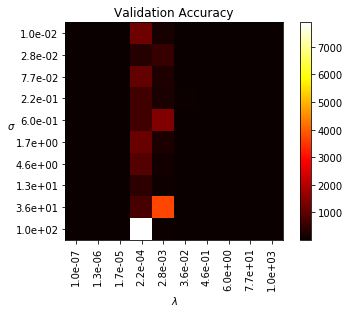

In [23]:
fig, ax = plt.subplots()

cax = ax.imshow(scores, cmap=plt.cm.hot)
# plt.scatter(min_sig, min_lam,
#          color='green', marker='+',s=20)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()

In [ ]:
# initialize model
krr_model = KRR(reg='d2f',
                lam=best_lambda,
                sigma=best_sigma)

# fit to data
krr_model.fit(x['data'], y['data'])

# predict
y_pred = krr_model.predict(x['plot'])


fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['plot'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||\partial^2 f||$')

# plot data
ax.scatter(x['data'], y['data'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()